In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

2022-04-01 15:31:32.929261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-01 15:31:32.929277: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp585", "historical", "hist-GHG"]

In [3]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_tas = create_predictdand_data(train_files)['tas'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["tas"].mean('member')

/perm/rd/pamc/conda/envs/climetbench/lib/python3.10/site-packages/eofs/standard.py:272: RuntimeWarning: invalid value encountered in true_divide
  return self._P[:, slicer] / np.sqrt(self._L[slicer])


In [4]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_tas = y_train_tas[~nan_train_mask]
assert len(X_train) == len(y_train_tas)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
tas_truth = tas_truth[~nan_test_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std

### Prepare model

In [7]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2022-04-01 15:31:43.635886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-01 15:31:43.635905: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-01 15:31:43.635923: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (romeo): /proc/driver/nvidia/version does not exist
2022-04-01 15:31:43.636087: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_tas.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [9]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

2022-04-01 15:31:43.686041: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78669D+06    |proj g|=  9.67251D+05


 This problem is unconstrained.



At iterate    1    f=  3.00289D+06    |proj g|=  2.70259D+05

At iterate    2    f=  2.78168D+06    |proj g|=  4.72897D+05

At iterate    3    f=  2.14325D+06    |proj g|=  2.41913D+05

At iterate    4    f=  1.82263D+06    |proj g|=  2.49466D+05

At iterate    5    f=  1.77628D+06    |proj g|=  2.85494D+04

At iterate    6    f=  1.76410D+06    |proj g|=  3.75357D+04

At iterate    7    f=  1.74407D+06    |proj g|=  1.43271D+04

At iterate    8    f=  1.72949D+06    |proj g|=  1.63253D+04

At iterate    9    f=  1.71725D+06    |proj g|=  8.36312D+03

At iterate   10    f=  1.70640D+06    |proj g|=  2.55238D+04

At iterate   11    f=  1.70408D+06    |proj g|=  3.07051D+03

At iterate   12    f=  1.70293D+06    |proj g|=  1.20869D+04

At iterate   13    f=  1.70220D+06    |proj g|=  7.83861D+03

At iterate   14    f=  1.70100D+06    |proj g|=  2.60050D+03

At iterate   15    f=  1.69983D+06    |proj g|=  3.46588D+03

At iterate   16    f=  1.69975D+06    |proj g|=  1.88847D+04

At iter

      fun: 1664059.9453270913
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.2809932 ,   1.434435  ,  -0.90624807,  -0.24801453,
        19.49341875,   5.64738553,   1.19643565,  -1.07189549,
         0.1336885 , -14.66461641,   2.70162398,  -0.52765722,
        -1.49367767,   5.25623172,  -1.40284894,  -4.77502047,
       -70.5632147 ,  -5.9585088 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 214
      nit: 186
     njev: 214
   status: 0
  success: True
        x: array([ 7.65808336e+00,  7.23214704e+00,  9.09569864e-02, -4.11568447e+00,
       -3.22602418e+00, -1.41236274e+00, -1.67686074e+00,  1.10410444e+01,
        2.36813935e+01, -3.25769000e+00,  6.54530954e+00,  9.57739193e+01,
        8.44533198e+01,  5.45062204e+01,  7.02197696e+01, -1.83105309e+00,
       -2.52983343e+00,  5.49701418e-01])


At iterate  186    f=  1.66406D+06    |proj g|=  7.05632D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18    186    214      1     0     0   7.056D+01   1.664D+06
  F =   1664059.9453270913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


### Predict on testing set

In [10]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std = np.sqrt(standard_posterior_var) * train_tas_std

In [11]:
# put output back into xarray format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])

posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=tas_truth.dims, coords=tas_truth.coords)

In [12]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

RMSE at 2050: 0.3123885957304286
RMSE at 2100: 0.3217394807753381
RMSE 2045-2055: 0.36583788569829073
RMSE 2090-2100: 0.3612333953187625
RMSE 2050-2100: 0.361742243233426


[Text(0.5, 1.0, 'Difference')]

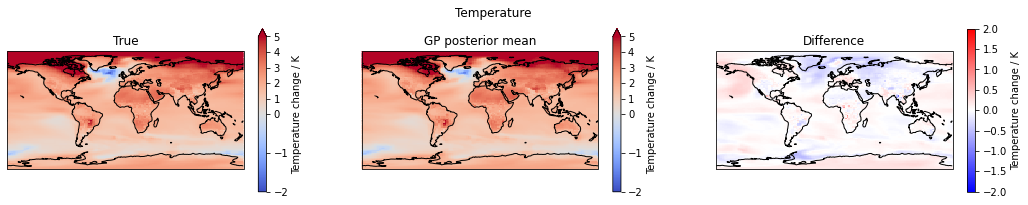

In [13]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- Mostly CO2
- Really just CO2
- Small noise variance

In [14]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.54970142]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,7.232869741383618
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,7.658555458859215
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.016183113717061874
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.7396594641390344
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.03775538771892648
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.03894672, 0.21798396, 0.17139539..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.14863095451649092
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[6.54674534, 95.77391931, 84.45331983..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.07665856035687107


In [29]:
# Save predictions
posterior_tas_data.to_netcdf('climatebench-gp-posterior-mean-tas-test-2019-2100.nc')
posterior_tas_std_data.to_netcdf('climatebench-gp-posterior-std-tas-test-2019-2100.nc')